# UPMaBoSS notebook for the cell fate model

This Jupyter notebook implements all the analyses presented in the `UPMaBoSS: a tool for dynamic cell population
modeling` manuscript by Stoll et al., which will be available on [bioRxiv.org](https://www.biorxiv.org/search/uppmaboss) in the coming days (as of 2019-05-24).

There are two options to run this notebook.

1) With the corresponding docker image

All necessary software and files are available in the
[docker image for the CoLoMoTo notebook](http://www.colomoto.org/notebook)
starting with version `2019-05-24`. Further information and usage instructions are available
in the documentation of the CoLoMoTo notebook.
Launch the docker application on your desktop using the *colomoto-docker* wrapper with the following command:

    colomoto-docker -V 2019-05-24
    
This notebook can then be found in the folder: `usecases/Population-level Cell Fate with UpPMaBoSS`.


2) By creating a conda environment locally

We suggest to download miniconda3 and create an environment (here named named *umb*) with the following command:

     conda create -n umb -c colomoto -c potassco pymaboss notebook seaborn ginsim-python
     
To launch this environment, you need to activate it with the following command before launching the jupyter notebook:

    conda activate umb
    jupyter notebook

UPMaBoSS computes the evolution and the dynamics of a population of cells taking into account both their intracellular and intercellular regulations.

Simulations with UPMaBoSS are based on a logical model describing the intracellular regulations (logical regulatory graph complemented with logical rules), taking into account cell death, cell division, and intercellular communications. 

The logical model of an individual cell is described as a MaBoSS model. At predefined intervals, the simulation of the cell population is stopped and the status of each cell of the population is updated according to the value of the variables representing cell death and cell division, and the value of the variables accounting for the activation or inhibition of signals coming from other cells. The simulation is then continued with the updated conditions until the maximum simulation time is reached. Since MaBoSS results are probabilistic, the simulation outputs of UpPMaBoSS can be interpreted as the behaviour of a cell population. 

To run UPMaBoSS, three files are needed: a model file (in BND format), a configuration file with the transition rates, the simulation parameters and the initial conditions (in CFG format), and a file defining the update parameters (in UPP format).


The notebook presented illustrate the use of UPMaBoSS with the analysis of a modified version of the cell fate model previously published by Calzone et al. (2010). Three files related to the logical model used for the analysis are provided together with this notebook:
- the model files: *CellFateModel_uppmaboss.bnd* and *CellFateModel_uppmaboss.cfg*
- the update configuration file for UPMaBoSS: *CellFateModel_uppmaboss.upp* 

The code included in the following cell sets the working environment, and particular load different libraries required to run the notebook.

In [1]:
# Set up working environment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np
import os
import shutil
import maboss
import ginsim


# Set seaborn style and create color maps: white-black scale and blue-light-red for ratios
sns.set_style("white")
colormap_scale = sns.light_palette("black", as_cmap=True)
colormap_ratios = sns.diverging_palette(240, 0, center='light', as_cmap=True)

# Shortcut to save figures with a common pattern and format
def save_figure(figure, title):
    figure.savefig("figure_%s.pdf" % title, bbox_inches="tight")

The original cell fate model (Calzone et al., 2010) was defined to study the cell fate decision process in response to the engagement of the death receptors TNFR and Fas.  Depending to the presence of the corresponding  ligands, several pathways can be activated: survival through NFkB activation, death through necrosis (NonACD), or apoptosis. 
This model has been extended to account for a documented activation of TNFalpha by NFkB (bold arrow), as well as by the addition of two output nodes DIVISION and DEATH, as shown in the regulatory graph using GINsim with the following command line. 

Downloading http://ginsim.org/sites/default/files/CellFate_multiscale.zginml

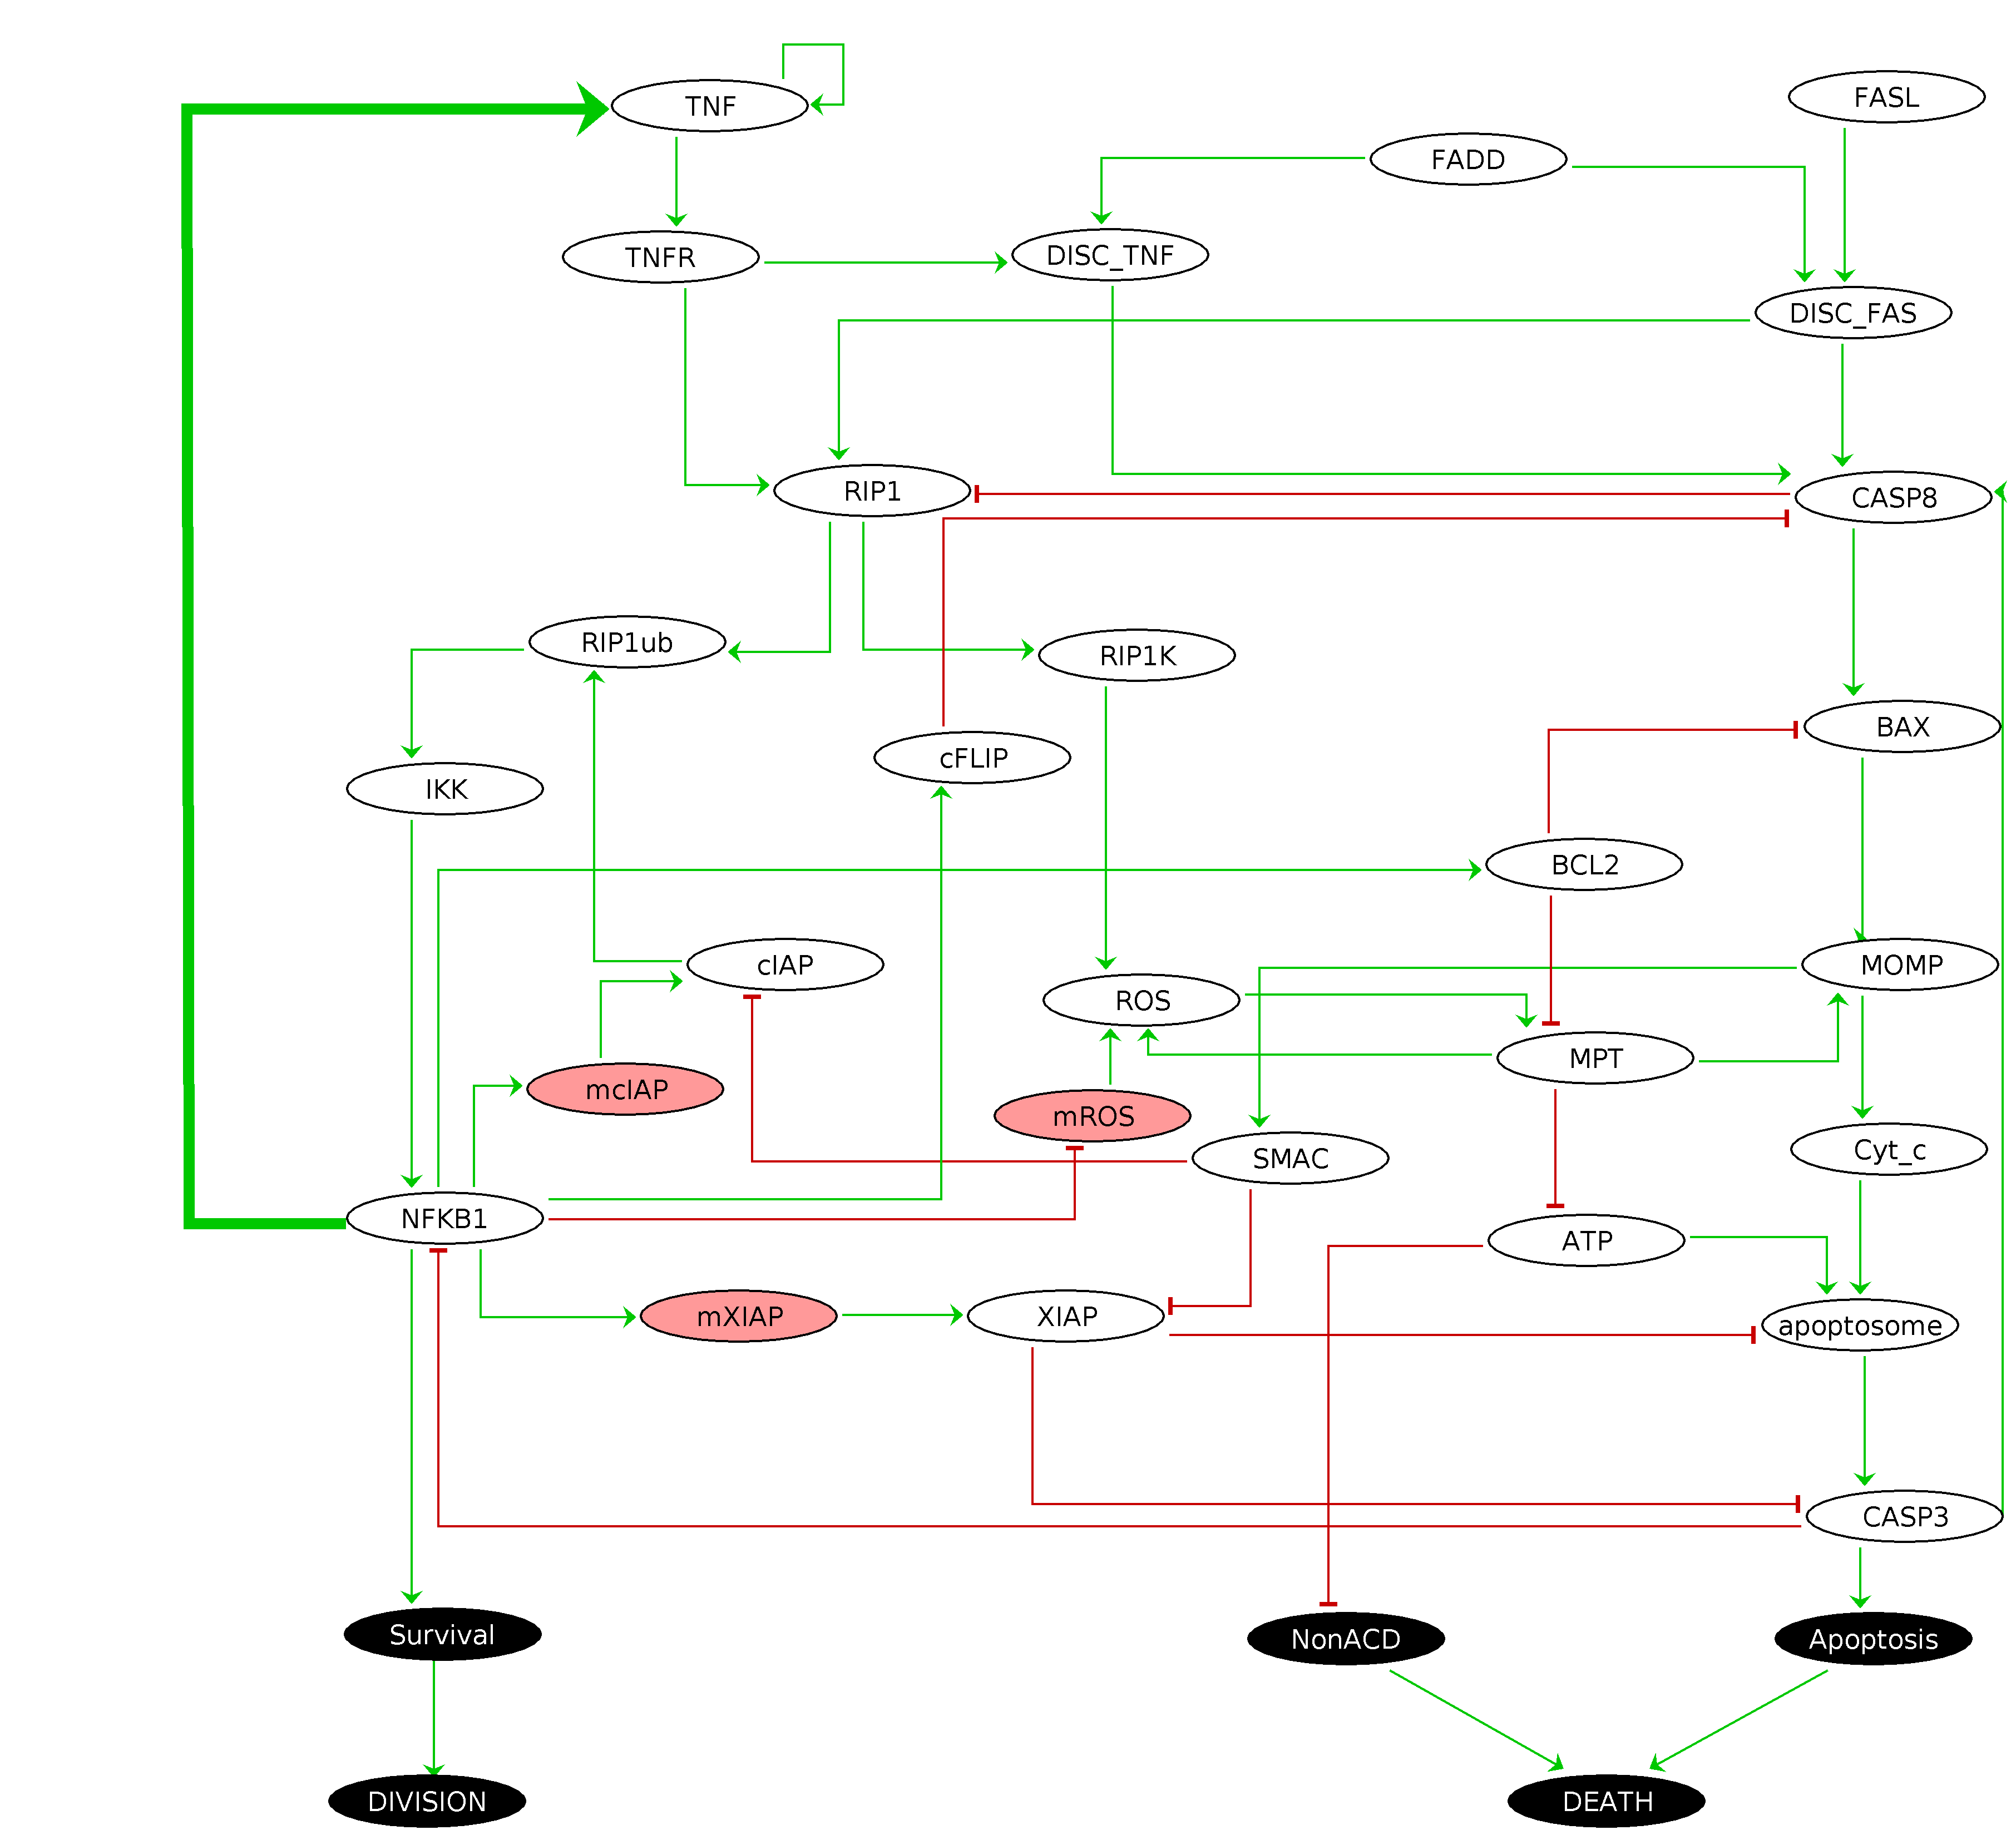

In [2]:
lrg = ginsim.load("http://ginsim.org/sites/default/files/CellFate_multiscale.zginml")
ginsim.show(lrg)

The BND file lists all the logical rules for each of the variables.
The CFG file defines all the parameters for the simulations (transition rates, simulation parameters and initial conditions).
The UPP file informs on the intercellular conditions and population updates.
These files are loaded with the code contained in the following cell.

In [3]:
# Set up the required files
bnd_file ="CellFateModel_uppmaboss.bnd"
cfg_WT = "CellFateModel_uppmaboss.cfg"
upp_file = "CellFateModel_uppmaboss.upp"

# MaBoSS simulation of the wild type model

Before running UPMaBoSS, we strongly suggest to run an initial simulation of the wild type model with MaBoSS for the whole simulation time. This enables the user to verify how the population behaves in a normal MaBoSS run without taking into account cell death or cell division.  Here, the total (virtual) simulation time is 48 hours. 
The output results are restricted to the three model nodes "Death", "Division" and "NFkB". Other nodes can be considered in the output, but the most important is to select all the nodes that are used for population updating, as shown in the UPP file below. By considering these nodes in the output, MaBoSS computes explicitly the values of these nodes.

In [4]:
ufile = open(upp_file, 'r') 
print(ufile.read())
ufile.close()

death = Death;
division = Division ;
$TNF_induc u= $ProdTNF_NFkB*p[(NFkB,Death) = (1,0)];
steps = 48;
MaBoSS = MaBoSS



Note that the variable "Death" monitors death by apoptosis or by non-apoptotic cell death, while the variable "Division" reports the activity of NFkB.

The following command lines load the wildtype model and set the maximal global simulation time to 48 hours:

In [5]:
# Load the Wild-Type model
model_WT = maboss.load(bnd_file, cfg_WT)

# Set some parameters in the cfg file: "max_time" 
# and select the variables considered to be internal (not appearing in the resulting csv file)
# here, only the two outputs will appear: Death and Division in the figures
model_48h = maboss.copy_and_update_parameters(model_WT, {'max_time':48})
for name in "mcIAP mXIAP mROS NonACD Apoptosis Survival TNF ATP FADD cIAP FASL TNFR DISC_TNF DISC_FAS RIP1 RIP1ub RIP1K IKK CASP8 BAX BCL2 ROS MPT MOMP SMAC Cyt_c XIAP apoptosome CASP3 cFLIP".split(' '):
    model_48h.network[name].is_internal = True


Next, we define the nodes considered in the output and launch the simulation with the following command lines:

In [8]:
model_48h.network.set_output(('Apoptosis','NonACD','Survival'))
run_48h = model_48h.run()

The result of the simulation can be displayed with the following command line:

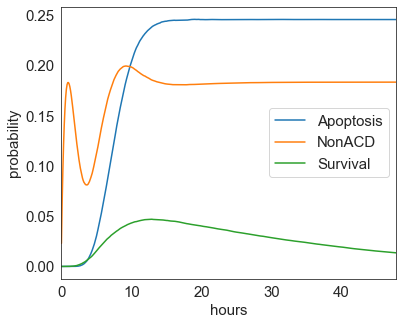

In [9]:
# Plot the results of the WT simulation
figure = plt.figure(figsize = (6,5))
plt.rcParams.update({'legend.fontsize': 15})
outPlot = run_48h.get_nodes_probtraj().plot(ax=plt.gca(),fontsize=15)
outPlot.set_xlabel("hours",fontsize=15)
outPlot.set_ylabel("probability",fontsize=15)
save_figure(figure, 'MaBoSS_phenotypes')

This graph shows the mean temporal profiles of the nodes Apoptosis, Division, NonACD and Survival computed for 100,000 trajectories (as specified in the BND file) simulations over 48h. 

# UPMaBoSS simulations

We now wish to explore the population dynamics for the cell fate model considering cell death, cell division and intercellular events. 
To do so, we divide the 48 hours into 48 runs (the variable "steps" is set to 48 in CellFateModel_uppmaboss.upp file) of 1 for each time steps (the variable "max_time" is set to 1 in CellFateModel_uppmaboss.cfg file). This choice of the value 1 is based on the analysis of the profile of the MaBoSS simulation above, as such a time-step enables to capture transient changes of activities of the output nodes Death, Division and NFkB.

## Wild Type simulations with and without the feedback

We consider two conditions: when the cells evolve without inter-cellular communication (model referred to as "NoFB") and when the presence of NFkB affects that status of other cells (model referred to as "WT"). The model with the feedback considers that NFkB activates TNFR in other cells. 

The following code cell run UpPMaBoSS on the WT model, calling iteratively 48 times MaBoSS and updating the input variables between each of these calls.

In [10]:
# Run UPMaBoSS on the WT model and collect population ratios
# A folder named "WT" "is created with the 48 runs
uppModel_WT = maboss.UpdatePopulation(model_WT, upp_file)
run_WT = uppModel_WT.run('WT')
pop_ratios_WT = run_WT.get_population_ratios('NFkB -> TNF')

Next, we create a model variant and launch a 48h UPMaBoSS simulation for the NoFB model:

In [11]:
# Create a variant without the population feedback NFkB -> TNF
model_NoFB = maboss.copy_and_update_parameters(model_WT, {'$ProdTNF_NFkB': 0})

# Run UPMaBoSS for the model without population feedback
# A folder named "NoFB" "is created with the 48 runs
uppModel_NoFB = maboss.UpdatePopulation(model_NoFB, upp_file)
run_NoFB = uppModel_NoFB.run('NoFB')
pop_ratios_NoFB = run_NoFB.get_population_ratios('No NFkB -> TNF')

We can now display the results of the two previous UPMaBoSS simulation in a single graph with the following command lines:

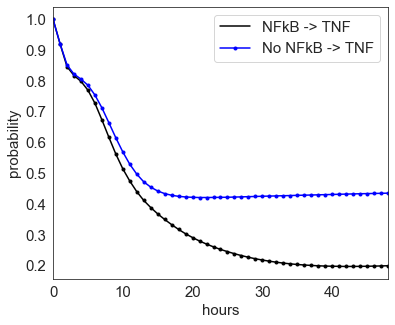

In [12]:
# Plot population ratio with/without population feedback
# A figure is saved in the folder with the name: "figure_ratios.pdf"
figure = plt.figure(figsize = (6,5))
plt.rcParams.update({'legend.fontsize': 15})
pop_ratios_WT.plot(style='.-k', legend=True,fontsize=15)
outPlot = pop_ratios_NoFB.plot(style='.-b', legend=True)
outPlot.set_xlabel("hours",fontsize=15)
outPlot.set_ylabel("probability",fontsize=15)
save_figure(figure, 'ratios')

In this graph, comparing the curves obtained after a pulse of TNF at t = 0 in the absence (blue curve) or in the presence (black curve) of the feedback from NFκB to TNFα, we see that the TNF paracrine loop leads to a significant decrease of the population size.

## Comparative simulations of different TNF treatments

In this section, we simulate the effect of several scenarios for TNF treatments on the wild type cell fate model. 

We first run a simulation for 48 hours without TNF treatment. 

In [13]:
# Create a model with no TNF (TNF OFF)
model_noTNF = model_WT.copy()
model_noTNF.network.set_istate('TNF', [1,0])

# Run UPMaBoSS for the model with no TNF
# A folder named "noTNF" "is created with the 48 runs
uppModel_noTNF = maboss.UpdatePopulation(model_noTNF, upp_file)
run_noTNF = uppModel_noTNF.run('noTNF')
pop_ratios_noTNF = run_noTNF.get_population_ratios('noTNF')

We then simulate a constant treatment for another 48h on a population of cells that received an initial TNF treatment (reTNF) and compare this simulation with the treatment of a population that was not initially treated with TNF (reTNF_noTNF).

In [14]:
# Create a model for a second treatment of TNF
model_reTNF = maboss.copy_and_update_parameters(model_WT, {'$TNF_induc': 20})

# Run UPMaBoSS for the second treatment of TNF after a WT run with TNF ON
# A folder named "TNF_reTNF" is created with the 48 runs
uppModel_TNF_reTNF = maboss.UpdatePopulation(model_reTNF, upp_file, previous_run=run_WT)
run_TNF_reTNF = uppModel_TNF_reTNF.run('TNF_reTNF')
pop_ratios_TNF_reTNF = run_TNF_reTNF.get_population_ratios('TNF')

# Run UPMaBoSS for a treatment of TNF after a run with no TNF (where TNF was initially OFF)
# A folder named "noTNF_reTNF" "is created with the 48 runs
uppModel_noTNF_reTNF = maboss.UpdatePopulation(model_reTNF, upp_file, previous_run=run_noTNF)
run_noTNF_reTNF = uppModel_noTNF_reTNF.run('noTNF_reTNF')
pop_ratios_noTNF_reTNF = run_noTNF_reTNF.get_population_ratios('TNF')

# Run UPMaBoSS for non treatment of TNF after a WT run with TNF ON
# A folder named "TNF_noTNF" "is created with the 48 runs
uppModel_TNF_noTNF = maboss.UpdatePopulation(model_WT, upp_file, previous_run=run_WT)
# note that model_WT has TNF initially ON, but this initial conditition is replaced by previous_run=run_WT
run_TNF_noTNF = uppModel_TNF_noTNF.run('TNF_noTNF')
pop_ratios_TNF_noTNF = run_TNF_noTNF.get_population_ratios('noTNF')

# Run UPMaBoSS for non treatment of TNF after a WT run with no TNF (where TNF was initially OFF)
# A folder named "noTNF_noTNF" "is created with the 48 runs
uppModel_noTNF_noTNF = maboss.UpdatePopulation(model_WT, upp_file, previous_run=run_noTNF)
run_noTNF_noTNF = uppModel_noTNF_noTNF.run('noTNF_noTNF')
pop_ratios_noTNF_noTNF = run_noTNF_noTNF.get_population_ratios('noTNF')


Next, we plot the population ratios computed for the two protocols: 
1. (Pulse of TNF) + TNF, 
2. (no pulse of TNF) + TNF. 

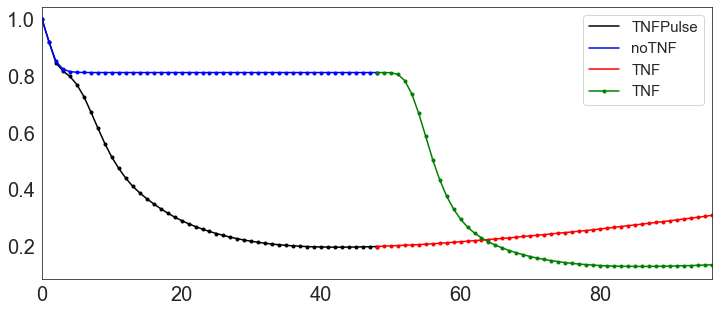

In [15]:
# Plot population ratios for a second treatment of TNF with or without the initial TNF stimulation
# A figure "figure_two_steps_ratios.pdf" is saved
figure = plt.figure(figsize = (12,5))
plt.rcParams.update({'legend.fontsize': 15})
pop_ratios_WT.name = "TNFPulse"
pop_ratios_WT.plot(style='.-k', legend=True,fontsize=20)
pop_ratios_noTNF.plot(style='.-b', legend=True)
pop_ratios_TNF_reTNF.plot(style='.-r', legend=True)
pop_ratios_noTNF_reTNF.plot(style='.-g', legend=True)
save_figure(figure, 'two_steps_ratios')

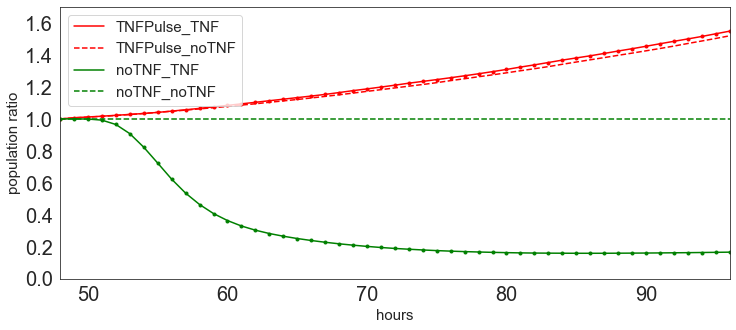

In [16]:
# Plot population ratios for a second treatment of TNF with or without the initial TNF stimulation, starting at time=48
# Plot the control in dashed lines
# A figure "figure_second_steps_ratios.pdf" is saved
figure = plt.figure(figsize = (12,5))
plt.rcParams.update({'legend.fontsize': 15})
plt.axis((48,96,0,1.7))
norm_pop_ratios_TNF_reTNF = pd.core.series.Series(index=pop_ratios_TNF_reTNF.index,data=pop_ratios_TNF_reTNF.values/pop_ratios_TNF_reTNF.values[0])
norm_pop_ratios_TNF_reTNF.name = "TNFPulse_TNF"
outPlot = norm_pop_ratios_TNF_reTNF.plot(style='.-r', legend=True,fontsize=20)

norm_pop_ratios_TNF_noTNF = pd.core.series.Series(index=pop_ratios_TNF_noTNF.index,data=pop_ratios_TNF_noTNF.values/pop_ratios_TNF_noTNF.values[0])
norm_pop_ratios_TNF_noTNF.name = "TNFPulse_noTNF"
norm_pop_ratios_TNF_noTNF.plot(style='--r', legend=True)

norm_pop_ratios_noTNF_reTNF = pd.core.series.Series(index=pop_ratios_noTNF_reTNF.index,data=pop_ratios_noTNF_reTNF.values/pop_ratios_noTNF_reTNF.values[0])
norm_pop_ratios_noTNF_reTNF.name = "noTNF_TNF"
norm_pop_ratios_noTNF_reTNF.plot(style='.-g', legend=True)

norm_pop_ratios_noTNF_noTNF = pd.core.series.Series(index=pop_ratios_noTNF_noTNF.index,data=pop_ratios_noTNF_noTNF.values/pop_ratios_noTNF_noTNF.values[0])
norm_pop_ratios_noTNF_noTNF.name = "noTNF_noTNF"
outPlot = norm_pop_ratios_noTNF_noTNF.plot(style='--g', legend=True)
outPlot.set_xlabel("hours",fontsize=15)

outPlot.set_ylabel("population ratio",fontsize=15)
save_figure(figure, 'second_steps_norm_ratios')


Based on these results, we conclude that the population that has received an initial treatment of TNF shows a resistance to the second TNF treatment, as the corresponding population ratio (in red) barely decreases compared to that of the population not submitted to an initial TNF pulse (in green). 

In conclusion, the cells that have not been treated previously  (in blue and green) respond better to the TNF treatment compared to those that have been previously treated (in black and red).

# Study TNF resistance

In this section, we study the conditions for TNF resistance by simulating single mutants of all 26 internal variables of the model. Each model mutant is defined by fixing the value of the corresponding variable to 0 (deletion) whatever its logical rule. 

The four scenarios combining initial and secondary TNF treatments are simulated for each of the mutant:
- no pulse of TNF followed by no TNF, 
- no pulse of TNF followed by TNF, 
- pulse of TNF followed by no TNF, 
- pulse of TNF followed by TNF.

A folder "TNF_sensitivity" is created in the working folder, which includes both WT and mutant simulations.

In [19]:
workdir = 'TNF_sensitivity'

def tnf_effect(workdir, model, name, df=None):
    "explore the effect of TNF in a given model variant"
    
    if df is None:
        df = pd.DataFrame()
    
    # Configuration of the model variants corresponding to combinations 
    # of (no) initial and secondary treatments
    model_pulse = model
    model_nopulse = model.copy()
    model_nopulse.network.set_istate('TNF', [1,0])
    
    model_tnf = maboss.copy_and_update_parameters(model, {'$TNF_induc':20})
    model_notnf = model
    
    # storage of all runs
    runs = {}
    
    # Simulations of no initial TNF pulse, then with or without constitutive TNF
    uppModel_no_pulse = maboss.UpdatePopulation(model_nopulse, upp_file)
    run_no_pulse = uppModel_no_pulse.run(os.path.join(workdir, name, 'nopulse'))
    
    uppModel_notnf = maboss.UpdatePopulation(model_notnf, upp_file, previous_run=run_no_pulse)
    runs['No pulse TNF, no TNF'] = uppModel_notnf.run(os.path.join(workdir, name, 'noPulse_noTNF'))
    uppModel_tnf = maboss.UpdatePopulation(model_tnf, upp_file, previous_run=run_no_pulse)
    runs['No pulse TNF, TNF'] = uppModel_tnf.run(os.path.join(workdir, name, 'noPulse_TNF'))
    
    # Simulations of initial TNF pulse, then with or without constitutive TNF
    uppModel_pulse = maboss.UpdatePopulation(model_pulse, upp_file)
    run_pulse = uppModel_pulse.run(os.path.join(workdir, name, 'pulse'))
    
    uppModel_notnf = maboss.UpdatePopulation(model_notnf, upp_file, previous_run=run_pulse)
    runs['Pulse TNF, no TNF'] = uppModel_notnf.run(os.path.join(workdir, name, 'pulse_noTNF'))
    uppModel_tnf = maboss.UpdatePopulation(model_tnf, upp_file, previous_run=run_pulse)
    runs['Pulse TNF, TNF'] = uppModel_tnf.run(os.path.join(workdir, name, 'pulse_TNF'))

    # Collection of population ratios
    for key in runs:
        pop_ratios = runs[key].get_population_ratios(key)
        if key not in df.columns:
            df[key] = pd.Series(name=name, dtype=np.float)
        df.at[name, key] = pop_ratios.iloc[-1]

    return df

The following code launches the simulations for all 26 mutants and for the four protocols considered.

Note that this could take a while, depending on your computer, it might take several hours. The user may skip the next three cells fo code.

In [16]:
# TNF sensitivity for the WT model
ratios = tnf_effect(workdir, model_WT, 'WT')

# List of all mutations to test
# Here all species will be mutated except for the output nodes
excluded = set( ( 'NonACD', 'Apoptosis', 'Survival', 'Division', 'Death', 'TNF', 'apoptosome') )
nodes = [ n for n in model_WT.network.names if n not in excluded ]
nodes.sort()


# TNF sensitivity for each mutant of the model
for mutant_node in nodes:
    print(mutant_node, end=' ')
    mut_model = maboss.copy_and_mutate(model_WT, [mutant_node], 'OFF')
    tnf_effect(workdir, mut_model, '%s' % mutant_node, ratios)

ATP BAX BCL2 CASP3 CASP8 Cyt_c DISC_FAS DISC_TNF FADD FASL IKK MOMP MPT NFkB RIP1 RIP1K RIP1ub ROS SMAC TNFR XIAP cFLIP cIAP mROS mXIAP mcIAP 

The final results are diplayed in terms of population ratios (white = 0 to black = 1) at 96h for each mutant in the form of a matrix using the following comand lines:

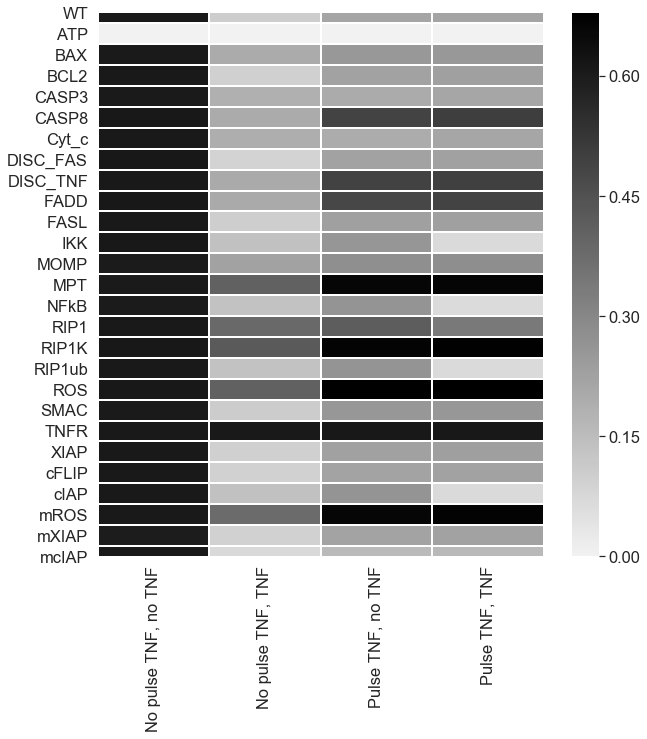

In [17]:
# Display the TNF sensitivity results for the WT condition and for all mutants 
figure = plt.figure(figsize = (10,10))
sns.set(font_scale=1.5)
sns.heatmap(ratios, annot=False, cmap=colormap_scale, linewidths=1)
save_figure(figure, 'heatmap')

In this matrix the protocols involving "No initial TNF treatment" (No pulse TNF) and "Initial TNF treatment" (Pulse TNF) are displayed separately. 

We can further process these simulation results to display the relative changes in population ratio for the two conditions, i.e. when the cells received an initial pulse of TNF treatment or not. The resulting ratios are displayed in a matrix after hierarchical clustering.


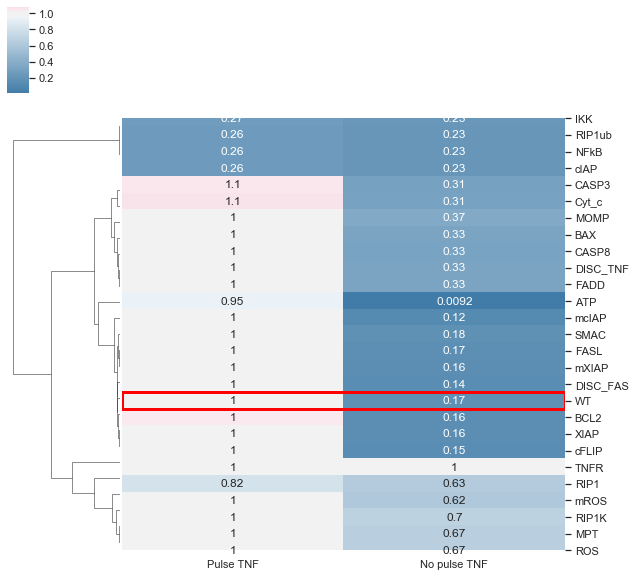

In [21]:
# More abstract summary: cluster of the ratios of ratios
ratios_ratios = pd.DataFrame()
ratios_ratios['Pulse TNF'] = ratios['Pulse TNF, TNF'] / ratios['Pulse TNF, no TNF']
ratios_ratios['No pulse TNF'] = ratios['No pulse TNF, TNF'] / ratios['No pulse TNF, no TNF']

sns.set(font_scale=1)
figure = sns.clustermap(ratios_ratios, annot=True, cmap=colormap_ratios, center=1, col_cluster=False)

# Add a rectangle around the WT row
wt_index = figure.dendrogram_row.reordered_ind.index(0)
figure.ax_heatmap.add_patch(Rectangle((0, wt_index), 2, 1, fill=False, edgecolor='red', lw=3))

save_figure(figure, 'cluster')

The relative changes in population ratio shown in this matrix correspond to the ratios between the population receiving the constitutive TNF treatment at t = 48 hours divided by the control population with no TNF at t = 48 hours. 
We consider that TNF treatment has an effect when the relative change in population ratio is reduced (ratio value below 1, in blue).

A first group of mutants, including IKK and other co-clustered mutants, but also  RIP1 knockdown, show no resistance. Indeed, TNF treatment reduces the population size, whether the cells were pre-treated by TNF or not.

For a second group of mutants, including RIP1K (in the bottom part) knockdowns, together with the wild type model, TNF constitutive treatment leads to a reduction in population size, but when the cells were pre-treated by a pulse of TNF, this effect disappears, hence indicating a resistance.

Finally, TNFR knockdown leads to insensitive cells, as expected.

The time dependant population ratios, for IKK and BCL2 mutants, are produced.

In [17]:
model_IKK = maboss.copy_and_mutate(model_WT, ['IKK'], 'OFF')
uppModel_IKK = maboss.UpdatePopulation(model_IKK, upp_file)
run_IKK = uppModel_IKK.run('IKK')
#
model_IKK_noTNF = model_IKK.copy()
model_IKK_noTNF.network.set_istate('TNF', [1,0])
# Run UPMaBoSS for the model with no TNF
uppModel_IKK_noTNF = maboss.UpdatePopulation(model_IKK_noTNF, upp_file)
run_IKK_noTNF = uppModel_IKK_noTNF.run('IKK_noTNF')


# Create a model for a second treatment of TNF
model_IKK_reTNF = maboss.copy_and_update_parameters(model_IKK, {'$TNF_induc': 20})

# Run UPMaBoSS for the second treatment of TNF after a WT run with TNF ON
# A folder named "TNF_reTNF" is created with the 48 runs
uppModel_IKK_TNF_reTNF = maboss.UpdatePopulation(model_IKK_reTNF, upp_file, previous_run=run_IKK)
run_IKK_TNF_reTNF = uppModel_IKK_TNF_reTNF.run('IKK_TNF_reTNF')
pop_ratios_IKK_TNF_reTNF = run_IKK_TNF_reTNF.get_population_ratios('TNF_reTNF')

# Run UPMaBoSS for a treatment of TNF after a run with no TNF (where TNF was initially OFF)
# A folder named "noTNF_reTNF" "is created with the 48 runs
uppModel_IKK_noTNF_reTNF = maboss.UpdatePopulation(model_IKK_reTNF, upp_file, previous_run=run_IKK_noTNF)
run_IKK_noTNF_reTNF = uppModel_IKK_noTNF_reTNF.run('IKK_noTNF_reTNF')
pop_ratios_IKK_noTNF_reTNF = run_IKK_noTNF_reTNF.get_population_ratios('noTNF_reTNF')

# Run UPMaBoSS for non treatment of TNF after a WT run with TNF ON
# A folder named "TNF_noTNF" "is created with the 48 runs
uppModel_IKK_TNF_noTNF = maboss.UpdatePopulation(model_IKK, upp_file, previous_run=run_IKK)
# note that model_WT has TNF initially ON, but this initial conditition is replaced by previous_run=run_WT
run_IKK_TNF_noTNF = uppModel_IKK_TNF_noTNF.run('IKK_TNF_noTNF')
pop_ratios_IKK_TNF_noTNF = run_IKK_TNF_noTNF.get_population_ratios('TNF_noTNF')

# Run UPMaBoSS for non treatment of TNF after a WT run with no TNF (where TNF was initially OFF)
# A folder named "noTNF_noTNF" "is created with the 48 runs
uppModel_IKK_noTNF_noTNF = maboss.UpdatePopulation(model_IKK, upp_file, previous_run=run_IKK_noTNF)
run_IKK_noTNF_noTNF = uppModel_IKK_noTNF_noTNF.run('IKK_noTNF_noTNF')
pop_ratios_IKK_noTNF_noTNF = run_IKK_noTNF_noTNF.get_population_ratios('noTNF_noTNF')

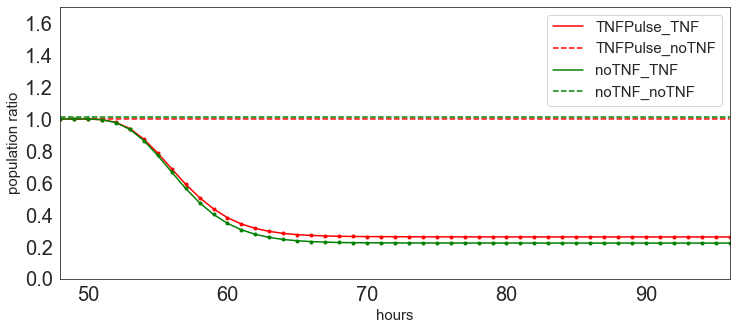

In [18]:
sns.set_style("white")
colormap_scale = sns.light_palette("black", as_cmap=True)
colormap_ratios = sns.diverging_palette(240, 0, center='light', as_cmap=True)
# Plot population ratios for a second treatment of TNF with or without the initial TNF stimulation, starting at time=48
# Plot the control in dashed lines
# A figure "figure_second_steps_ratios.pdf" is saved
figure = plt.figure(figsize = (12,5))
plt.rcParams.update({'legend.fontsize': 15})
plt.axis((48,96,0,1.7))
norm_pop_ratios_IKK_TNF_reTNF = pd.core.series.Series(index=pop_ratios_IKK_TNF_reTNF.index,data=pop_ratios_IKK_TNF_reTNF.values/pop_ratios_IKK_TNF_reTNF.values[0])
norm_pop_ratios_IKK_TNF_reTNF.name = "TNFPulse_TNF"
outPlot = norm_pop_ratios_IKK_TNF_reTNF.plot(style='.-r', legend=True,fontsize=20)

norm_pop_ratios_IKK_TNF_noTNF = pd.core.series.Series(index=pop_ratios_IKK_TNF_noTNF.index,data=pop_ratios_IKK_TNF_noTNF.values/pop_ratios_IKK_TNF_noTNF.values[0])
norm_pop_ratios_IKK_TNF_noTNF.name = "TNFPulse_noTNF"
norm_pop_ratios_IKK_TNF_noTNF.plot(style='--r', legend=True)

norm_pop_ratios_IKK_noTNF_reTNF = pd.core.series.Series(index=pop_ratios_IKK_noTNF_reTNF.index,data=pop_ratios_IKK_noTNF_reTNF.values/pop_ratios_IKK_noTNF_reTNF.values[0])
norm_pop_ratios_IKK_noTNF_reTNF.name = "noTNF_TNF"
norm_pop_ratios_IKK_noTNF_reTNF.plot(style='.-g', legend=True)
## add 0.005 to pop ratio because is is the same than TNF_noTNF
norm_pop_ratios_IKK_noTNF_noTNF = pd.core.series.Series(index=pop_ratios_IKK_noTNF_noTNF.index,data=.01+pop_ratios_IKK_noTNF_noTNF.values/pop_ratios_IKK_noTNF_noTNF.values[0])
norm_pop_ratios_IKK_noTNF_noTNF.name = "noTNF_noTNF"
outPlot = norm_pop_ratios_IKK_noTNF_noTNF.plot(style='--g', legend=True)
outPlot.set_xlabel("hours",fontsize=15)

outPlot.set_ylabel("population ratio",fontsize=15)
save_figure(figure, 'second_steps_norm_ratios_IKK')


In [19]:
model_RIP1K = maboss.copy_and_mutate(model_WT, ['RIP1K'], 'OFF')
uppModel_RIP1K = maboss.UpdatePopulation(model_RIP1K, upp_file)
run_RIP1K = uppModel_RIP1K.run('RIP1K')
#
model_RIP1K_noTNF = model_RIP1K.copy()
model_RIP1K_noTNF.network.set_istate('TNF', [1,0])
# Run UPMaBoSS for the model with no TNF
uppModel_RIP1K_noTNF = maboss.UpdatePopulation(model_RIP1K_noTNF, upp_file)
run_RIP1K_noTNF = uppModel_RIP1K_noTNF.run('RIP1K_noTNF')


# Create a model for a second treatment of TNF
model_RIP1K_reTNF = maboss.copy_and_update_parameters(model_RIP1K, {'$TNF_induc': 20})

# Run UPMaBoSS for the second treatment of TNF after a WT run with TNF ON
# A folder named "TNF_reTNF" is created with the 48 runs
uppModel_RIP1K_TNF_reTNF = maboss.UpdatePopulation(model_RIP1K_reTNF, upp_file, previous_run=run_RIP1K)
run_RIP1K_TNF_reTNF = uppModel_RIP1K_TNF_reTNF.run('RIP1K_TNF_reTNF')
pop_ratios_RIP1K_TNF_reTNF = run_RIP1K_TNF_reTNF.get_population_ratios('TNF_reTNF')

# Run UPMaBoSS for a treatment of TNF after a run with no TNF (where TNF was initially OFF)
# A folder named "noTNF_reTNF" "is created with the 48 runs
uppModel_RIP1K_noTNF_reTNF = maboss.UpdatePopulation(model_RIP1K_reTNF, upp_file, previous_run=run_RIP1K_noTNF)
run_RIP1K_noTNF_reTNF = uppModel_RIP1K_noTNF_reTNF.run('RIP1K_noTNF_reTNF')
pop_ratios_RIP1K_noTNF_reTNF = run_RIP1K_noTNF_reTNF.get_population_ratios('noTNF_reTNF')

# Run UPMaBoSS for non treatment of TNF after a WT run with TNF ON
# A folder named "TNF_noTNF" "is created with the 48 runs
uppModel_RIP1K_TNF_noTNF = maboss.UpdatePopulation(model_RIP1K, upp_file, previous_run=run_RIP1K)
# note that model_WT has TNF initially ON, but this initial conditition is replaced by previous_run=run_WT
run_RIP1K_TNF_noTNF = uppModel_RIP1K_TNF_noTNF.run('RIP1K_TNF_noTNF')
pop_ratios_RIP1K_TNF_noTNF = run_RIP1K_TNF_noTNF.get_population_ratios('TNF_noTNF')

# Run UPMaBoSS for non treatment of TNF after a WT run with no TNF (where TNF was initially OFF)
# A folder named "noTNF_noTNF" "is created with the 48 runs
uppModel_RIP1K_noTNF_noTNF = maboss.UpdatePopulation(model_RIP1K, upp_file, previous_run=run_RIP1K_noTNF)
run_RIP1K_noTNF_noTNF = uppModel_RIP1K_noTNF_noTNF.run('RIP1K_noTNF_noTNF')
pop_ratios_RIP1K_noTNF_noTNF = run_RIP1K_noTNF_noTNF.get_population_ratios('noTNF_noTNF')

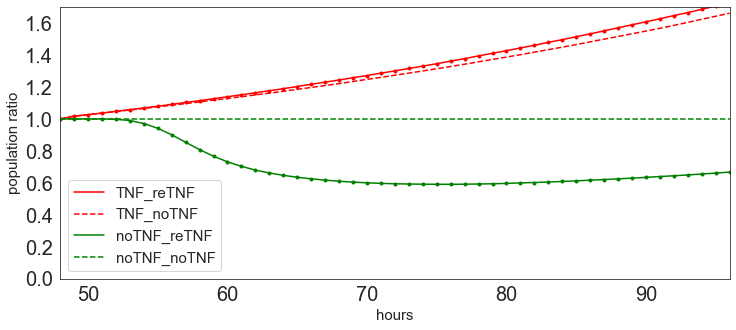

In [20]:
# Plot population ratios for a second treatment of TNF with or without the initial TNF stimulation, starting at time=48
# Plot the control in dashed lines
# A figure "figure_second_steps_ratios.pdf" is saved
figure = plt.figure(figsize = (12,5))
plt.rcParams.update({'legend.fontsize': 15})
plt.axis((48,96,0,1.7))
norm_pop_ratios_RIP1K_TNF_reTNF = pd.core.series.Series(index=pop_ratios_RIP1K_TNF_reTNF.index,data=pop_ratios_RIP1K_TNF_reTNF.values/pop_ratios_RIP1K_TNF_reTNF.values[0])
norm_pop_ratios_RIP1K_TNF_reTNF.name = "TNF_reTNF"
outPlot = norm_pop_ratios_RIP1K_TNF_reTNF.plot(style='.-r', legend=True,fontsize=20)

norm_pop_ratios_RIP1K_TNF_noTNF = pd.core.series.Series(index=pop_ratios_RIP1K_TNF_noTNF.index,data=pop_ratios_RIP1K_TNF_noTNF.values/pop_ratios_RIP1K_TNF_noTNF.values[0])
norm_pop_ratios_RIP1K_TNF_noTNF.name = "TNF_noTNF"
norm_pop_ratios_RIP1K_TNF_noTNF.plot(style='--r', legend=True)

norm_pop_ratios_RIP1K_noTNF_reTNF = pd.core.series.Series(index=pop_ratios_RIP1K_noTNF_reTNF.index,data=pop_ratios_RIP1K_noTNF_reTNF.values/pop_ratios_RIP1K_noTNF_reTNF.values[0])
norm_pop_ratios_RIP1K_noTNF_reTNF.name = "noTNF_reTNF"
norm_pop_ratios_RIP1K_noTNF_reTNF.plot(style='.-g', legend=True)
norm_pop_ratios_RIP1K_noTNF_noTNF = pd.core.series.Series(index=pop_ratios_RIP1K_noTNF_noTNF.index,data=pop_ratios_RIP1K_noTNF_noTNF.values/pop_ratios_RIP1K_noTNF_noTNF.values[0])
norm_pop_ratios_RIP1K_noTNF_noTNF.name = "noTNF_noTNF"
outPlot = norm_pop_ratios_RIP1K_noTNF_noTNF.plot(style='--g', legend=True)
outPlot.set_xlabel("hours",fontsize=15)

outPlot.set_ylabel("population ratio",fontsize=15)
save_figure(figure, 'second_steps_norm_ratios_RIP1K')